In [ ]:
from google.colab import drive, auth
import sys
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import librosa
import matplotlib.pyplot as plt
import csv
from IPython.display import Audio

#sklearn libraries
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#tensorflow for modles
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv2D, MaxPooling2D, Flatten, concatenate, Reshape, BatchNormalization
import tensorflow_hub as hub
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback,EarlyStopping
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

#mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#declare sampling rate
sampling_rate = 16000#read data
bird_df = pd.read_csv('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/RG/3_species/train_val.csv')
bird_df.head(1)

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data
0,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,EUROPE,train


In [ ]:
#Gather the training data from the main dataset
bird_train_df = bird_df[bird_df['data'] == 'train']
bird_train_df.shape

(657, 9)

In [ ]:
#count the number of species
species_counts = bird_train_df['primary_label'].value_counts()
print(species_counts)

comsan     244
eaywag1    216
barswa     197
Name: primary_label, dtype: int64


In [ ]:
#lets create a separate validation set
bird_val_df =  bird_df[bird_df['data'] == 'val']
bird_val_df.shape

(283, 9)

In [ ]:
# Group the dataframe by the "primary_label" column and calculate the total duration for each group
label_durations_train = bird_train_df.groupby('primary_label')['duration_secs_32000'].sum()

# Print the result
print(label_durations_train)


# Group the dataframe by the "primary_label" column and calculate the total duration for each group
label_durations_val = bird_val_df.groupby('primary_label')['duration_secs_32000'].sum()

# Print the result
print(label_durations_val)

primary_label
barswa     7418.617906
comsan     7488.164156
eaywag1    7235.116813
Name: duration_secs_32000, dtype: float64
primary_label
barswa     2956.129906
comsan     2823.414500
eaywag1    3083.174312
Name: duration_secs_32000, dtype: float64


In [ ]:
train_class_counts = bird_train_df['primary_label'].value_counts()
val_class_counts = bird_val_df['primary_label'].value_counts()

print("Train Class Counts:")
print(train_class_counts)

print("Validation Class Counts:")
print(val_class_counts)

Train Class Counts:
comsan     244
eaywag1    216
barswa     197
Name: primary_label, dtype: int64
Validation Class Counts:
comsan     105
eaywag1     93
barswa      85
Name: primary_label, dtype: int64


In [ ]:
#Count the number of audio files that are exactly 15 seconds
num_15_sec = len(bird_train_df[bird_train_df['duration_secs_32000'] > 5])

#Count the number of audio files that are less than 15 seconds
num_less_than_15_sec = len(bird_train_df[bird_train_df['duration_secs_32000'] < 6])

print("Number of audio files that are exactly 15 seconds:", num_15_sec)
print("Number of audio files that are less than 15 seconds:", num_less_than_15_sec)

Number of audio files that are exactly 15 seconds: 657
Number of audio files that are less than 15 seconds: 34


In [ ]:
# Assuming bird_train_df is your DataFrame containing the audio information
# Find audio files with duration less than 6 seconds
audios_less_than_6_sec = bird_train_df[bird_train_df['duration_secs_32000'] < 10]

# Group the DataFrame by primary_label and get the count of audio files in each group
grouped_by_primary_label = audios_less_than_6_sec.groupby('primary_label').size()

# Display the count of audio files for each primary_label
print(grouped_by_primary_label)

primary_label
barswa     30
comsan     73
eaywag1    41
dtype: int64


In [ ]:
#get the audio path
audio_path = '/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/data/train/librosa_loaded/'

#Function to load the audio
def load_audio(file_name):
    audio = np.load(audio_path + file_name)
    return audio

In [ ]:
#chunk the audio into 5 sec frame with no overlaps
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 5.0,
      hop_size_s: float = 2.5,
      sample_rate = sampling_rate,
      ) -> np.ndarray:

    """Helper function for framing audio for inference."""
    """ using tf.signal """
    if window_size_s is None or window_size_s < 0:
        return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=True)
    return framed_audio

In [ ]:
#extract mfcc from frames
def extract_mfcc_from_frames(framed_audio, class_label, sample_rate=16000, n_mfcc=20):
  mfcc_frames = []
  target_label = []
  for frame in framed_audio:
    frame = np.array(frame)

    #Extract mfcc from the main audio frame
    mfcc = librosa.feature.mfcc(y=frame, sr=sample_rate, n_mfcc=n_mfcc)

    #Transpose the MFCC matrix
    transposed_mfcc = mfcc.T

    #lets get the mfcc
    mfcc_frames.append(transposed_mfcc)

    #append the labels for every frame
    target_label.append(class_label)

  return mfcc_frames,target_label

In [ ]:
#extract the final features
def extract_final_features_from_dataframe(df):
    mfccs = []
    target_labels = []
    for index, row in df.iterrows():
        file_name = str(row['filename_npy'])
        class_label = row["primary_label"]
        duration = row['duration_secs_32000']
        if duration < 10:
            # Load the audio using the load_audio function
            audio = load_audio(file_name)
            # Calculate the time stretch factor to make the audio 10 seconds long
            time_stretch_factor = 10 / duration
            # Resample the audio to make it 10 seconds long
            audio_stretched = librosa.resample(audio, orig_sr=sampling_rate, target_sr=int(sampling_rate * time_stretch_factor))
            framed_audio = frame_audio(audio_stretched)  # Frame the time-stretched audio into 5-second segments
        else:
            # For audios with duration >= 10 seconds, proceed as before
            audio = load_audio(file_name)  # Load the audio using the load_audio function
            framed_audio = frame_audio(audio)  # Frame the audio into 5-second segments

        mfcc_frames, target_label = extract_mfcc_from_frames(framed_audio, class_label, sample_rate=sampling_rate)  # Extract MFCC features for each frame
        mfccs.extend(mfcc_frames)
        target_labels.extend(target_label)
    return mfccs, target_labels

In [ ]:
#let us get the encoded y_train and y_val
def encode_labels(y_train, y_val):
    # Perform one-hot encoding on y_train
    le = LabelEncoder()
    encoded_y_train = to_categorical(le.fit_transform(y_train))

    # Perform one-hot encoding on y_val
    le = LabelEncoder()
    encoded_y_val = to_categorical(le.fit_transform(y_val))

    return encoded_y_train, encoded_y_val

In [ ]:
#let us create a function to shuffle the data
def shuffle_data(x, y, random_state=1234):
    num_samples = x.shape[0]
    random_indices = np.random.RandomState(random_state).permutation(num_samples)
    x_shuffled = x[random_indices]
    y_shuffled = y[random_indices]
    return x_shuffled, y_shuffled

In [ ]:
def scale_data(data):
    # Reshape the data to 2D array
    num_samples, num_time_steps, num_features = data.shape
    data_reshaped = data.reshape(num_samples, num_features * num_time_steps)

    # Create the MinMaxScaler object and fit it to the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_reshaped)

    # Reshape the scaled data back to its original shape
    data_scaled = data_scaled.reshape(num_samples, num_time_steps, num_features)

    return data_scaled

In [ ]:
#extract the mfcc embeddings from the model
mfcc_embeddings, labels = extract_final_features_from_dataframe(bird_train_df)

In [ ]:
#lets extract mfcc of first 5 rows
mfcc_embeddings[:1]

[array([[-640.8579   ,   64.677185 ,  -62.988552 , ...,   -6.7448916,
           -1.0803337,   -1.5052841],
        [-367.0238   ,   61.163193 ,  -64.072556 , ...,   -6.0492578,
          -10.800379 ,   -6.3168383],
        [-292.5032   ,   58.88469  ,  -67.405975 , ...,   -2.8861198,
           -7.559266 ,   -2.872631 ],
        ...,
        [-276.97238  ,   53.687866 ,  -43.175415 , ...,   -7.3569508,
           -5.576524 ,    1.9049327],
        [-269.13995  ,   34.2004   ,  -37.430283 , ...,    3.6669822,
           -1.3040459,   -2.1778526],
        [-294.32895  ,   27.14126  ,  -45.10728  , ...,   10.434868 ,
           -0.9374119,   -4.9370155]], dtype=float32)]

In [ ]:
#verify the shapes
x_train = np.array(mfcc_embeddings)
y_train = np.array(labels)
print(x_train.shape)
print(y_train.shape)

(9292, 157, 20)
(9292,)


In [ ]:
#lets extract the embeddings
val_embeddings, val_labels = extract_final_features_from_dataframe(bird_val_df)

In [ ]:
val_embeddings[:1]

[array([[-340.6138   ,  127.00826  ,   44.271774 , ...,   10.514736 ,
           -0.6833378,   11.0607815],
        [-283.6167   ,  124.63982  ,   38.063232 , ...,   11.196489 ,
            0.567252 ,    6.3750343],
        [-275.97565  ,  124.30683  ,   34.929054 , ...,    5.1549063,
            2.2961612,    3.1506374],
        ...,
        [-255.79277  ,  143.95294  ,   43.216595 , ...,    2.4150612,
            1.5392418,   -1.5801059],
        [-256.25858  ,  140.16705  ,   39.414555 , ...,    4.858892 ,
            5.822331 ,    3.4978468],
        [-267.41135  ,  131.66406  ,   34.269558 , ...,    3.8172016,
            1.4814109,    1.075378 ]], dtype=float32)]

In [ ]:
#verify the val data shapes
x_val = np.array(val_embeddings)
y_val = np.array(val_labels)
print(x_val.shape)
print(y_val.shape)

(3734, 157, 20)
(3734,)


In [ ]:
#lets call the function to encode y
y_train_encoded, y_val_encoded = encode_labels(y_train, y_val)

In [ ]:
#lets verify the shape
print(y_train_encoded.shape)
print(y_val_encoded.shape)

(9292, 3)
(3734, 3)


In [ ]:
# Example usage:
x_train_scaled = scale_data(x_train)
x_val_scaled = scale_data(x_val)

In [ ]:
#shuffle both train and validation sets
x_shuffled_train, y_shuffled_train = shuffle_data(x_train_scaled, y_train_encoded)
x_shuffled_val, y_shuffled_val = shuffle_data(x_val_scaled, y_val_encoded)

print(x_shuffled_train.shape)
print(y_shuffled_train.shape)

print(x_shuffled_val.shape)
print(y_shuffled_val.shape)
x_shuffled_val[:1]

(9292, 157, 20)
(9292, 3)
(3734, 157, 20)
(3734, 3)


array([[[0.612058  , 0.62625223, 0.57737535, ..., 0.47373798,
         0.44438168, 0.41215697],
        [0.63060004, 0.6181207 , 0.59327424, ..., 0.40053362,
         0.44297874, 0.48388407],
        [0.62279713, 0.5889836 , 0.59421086, ..., 0.45056835,
         0.49643177, 0.4452399 ],
        ...,
        [0.6172409 , 0.668277  , 0.64236915, ..., 0.3911785 ,
         0.42433697, 0.3296659 ],
        [0.6196313 , 0.65405166, 0.54681635, ..., 0.41345203,
         0.48666978, 0.3894589 ],
        [0.6062392 , 0.6452148 , 0.5056199 , ..., 0.5643135 ,
         0.5403969 , 0.34096706]]], dtype=float32)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def train_sequential_model(x_train, y_train, x_val, y_val, learning_rate=0.002, batch_size=32, n_classes=3, epochs=150):
    input_shape = x_train.shape[1:]  # Shape of one sample in x_train

    model = Sequential()
    model.add(LSTM(256, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(48, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(n_classes, activation='softmax'))  # Output layer with n_classes units

    model.summary()

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Define the early stopping callback
    earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

    # Train the model
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        batch_size=batch_size, callbacks=[earlystop], epochs=epochs)

    return model, history


In [ ]:
#call the model
model, history = train_sequential_model(x_shuffled_train, y_shuffled_train, x_shuffled_val, y_shuffled_val, learning_rate=0.002, batch_size=32, n_classes=3, epochs=150)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256)               283648    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 48)                3120      
                                                                 
 dropout_11 (Dropout)        (None, 48)               

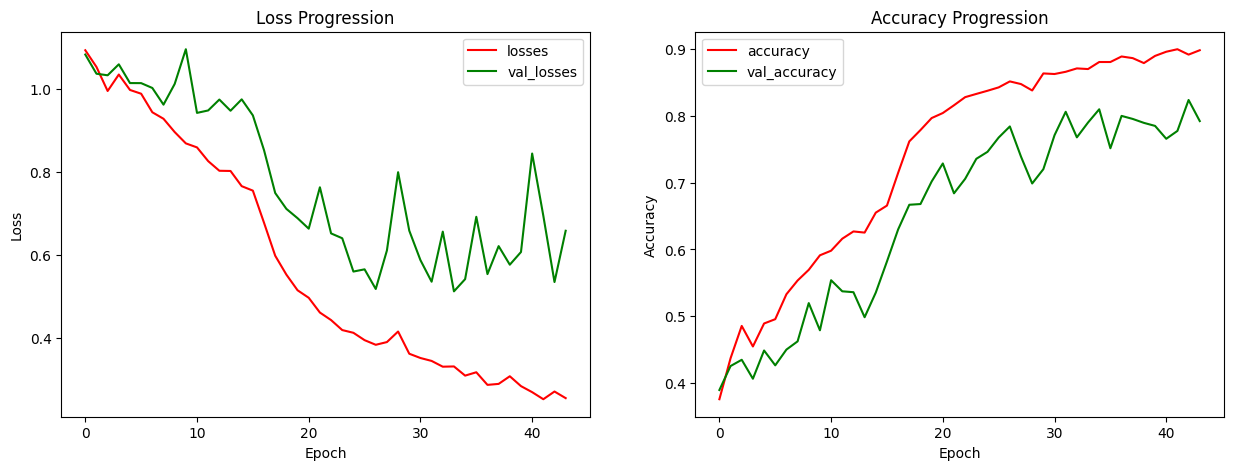

In [ ]:
#lets plot the accuracy and the loss graph
import matplotlib.pyplot as plt

# Plot the training and validation accuracy and losses
num_epochs = len(history.history['loss'])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(range(num_epochs), history.history['loss'], color='red', label='losses')
axes[0].plot(range(num_epochs), history.history['val_loss'], color='green', label='val_losses')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Progression')
axes[0].legend()

axes[1].plot(range(num_epochs), history.history['accuracy'], color='red', label='accuracy')
axes[1].plot(range(num_epochs), history.history['val_accuracy'], color='green', label='val_accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Progression')
axes[1].legend()

plt.show()


In [ ]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions.
test_pred_train = np.argmax(model.predict(x_shuffled_train), axis=-1)
print(test_pred_train)

291/291 [==============================] - 83s 275ms/step
[2 1 1 ... 0 2 0]


In [ ]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions.
test_pred = np.argmax(model.predict(x_shuffled_val), axis=-1)
print(test_pred)

117/117 [==============================] - 24s 205ms/step
[2 2 0 ... 1 2 0]


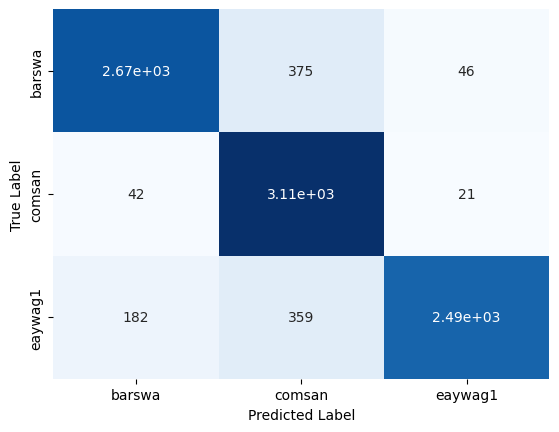

              precision    recall  f1-score   support

           0      0.923     0.864     0.892      3090
           1      0.809     0.980     0.886      3171
           2      0.974     0.822     0.891      3031

    accuracy                          0.890      9292
   macro avg      0.902     0.888     0.890      9292
weighted avg      0.901     0.890     0.890      9292



In [ ]:
#Training accuracy plots
#plot the confusion matrix
class_label = ['barswa',  'comsan',  'eaywag1']

# Create a confusion matrix as a 2D array.
from sklearn import metrics

y_train_1d = np.argmax(y_shuffled_train, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_train_1d, test_pred_train)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_train_1d, test_pred_train, digits=3, zero_division='warn'))

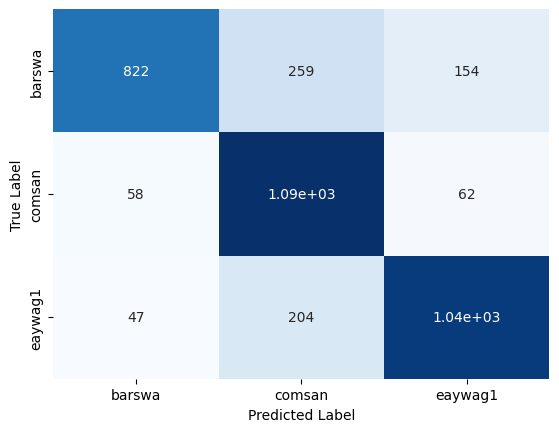

              precision    recall  f1-score   support

           0      0.887     0.666     0.760      1235
           1      0.701     0.901     0.789      1208
           2      0.828     0.806     0.817      1291

    accuracy                          0.790      3734
   macro avg      0.805     0.791     0.789      3734
weighted avg      0.807     0.790     0.789      3734



In [ ]:
#plot the confusion matrix
class_label = ['barswa',  'comsan',  'eaywag1']

# Create a confusion matrix as a 2D array.
from sklearn import metrics

y_val_1d = np.argmax(y_shuffled_val, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_val_1d, test_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_val_1d, test_pred, digits=3, zero_division='warn'))

#### Hyperparameter tuning:

| Training accuracy | Validation accuracy | learning rate | optimizer  | gaussian noise (delta) |  pitch shift |  overlaps |  time stretch |
|:-:                |:-:                  |:-:           |:-:       |:-:         |:-:    |:-:     |:-:      
| 0.60              | 0.54               | 0.002          | Adam    | No       | No          | No       | yes                | 3                | yes            |
| 0.51               | 0.45                 | <font color="red">0.01</font>     | Adam     | No       | No         | yes       | 0.3                | 3                | yes            |
| 0.73               | 0.52                 | 0.002          | <font color="red">SGD</font>  | No     |No           | yes       | 0.3                | 3                | yes,1            |

In [ ]:
model.save('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/HS/2blstm.model.h5')

NameError: ignored